# Annotation with TensorFlow Object Detection API
This sample colab illustrates how to use an utility function that's part of TensorFlow Object Detection API to manually annotate images for an Object Detection task.
Learn more about TensorFlow Object Detection API [here](https://blog.tensorflow.org/2020/07/tensorflow-2-meets-object-detection-api.html).

In [31]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from six import BytesIO
from pathlib import Path
import tensorflow as tf
%matplotlib inline

## Install Object Detection API

In [2]:
!git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 2798, done.
remote: Counting objects: 100% (2798/2798), done.
remote: Compressing objects: 100% (2434/2434), done.
remote: Total 2798 (delta 567), reused 1406 (delta 328), pack-reused 0
Receiving objects: 100% (2798/2798), 57.73 MiB | 34.13 MiB/s, done.
Resolving deltas: 100% (567/567), done.


In [3]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install -q .

object_detection/protos/input_reader.proto: warning: Import object_detection/protos/image_resizer.proto but not used.


In [4]:
from object_detection.utils import colab_utils
from object_detection.utils import visualization_utils as viz_utils

## Download data for annotation

Download the Wild Fire Smoke images dataset to annotate

In [5]:
%%bash
git clone https://github.com/aiformankind/wildfire-smoke-detection-camera

Cloning into 'wildfire-smoke-detection-camera'...
Checking out files: 100% (4062/4062), done.


In [7]:
PATH = Path('wildfire-smoke-detection-camera/input')

In [15]:
image_paths = list([p for p in (PATH/'images').glob('*')])
annotation_paths = list([p.stem + '.jpeg' for p in (PATH/'annotations/xmls').glob('*')])

non_annotated = []
for path in image_paths:
  if path.name not in annotation_paths:
    non_annotated.append(str(path))

print("Total images: ", len(image_paths))
print("Annotated images: ", len(annotation_paths))
print("Non annotated images: ", len(non_annotated))

Total images:  3292
Annotated images:  744
Non annotated images:  2548


Utility method to load an image from path into a uint8 numpy array with shape
  (height, width, channels), where channels=3 for RGB.

In [16]:
def load_image_into_numpy_array(path):
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  image_np = np.array(image.getdata(), dtype=np.uint8)
  return image_np.reshape((im_height, im_width, 3))

For testing select a random subset of the images (we don't want load all images)

In [21]:
sample_size = 9
indexes = np.random.randint(len(non_annotated), size=sample_size)
sample_paths = [non_annotated[idx] for idx in indexes]

## Annotate images

Load the selected random images into numpy arrays

In [22]:
images_np = [load_image_into_numpy_array(str(p)) for p in sample_paths]

In [23]:
boxes = []
colab_utils.annotate(images_np, box_storage_pointer=boxes)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

In [28]:
boxes

[None,
 array([[0.537    , 0.1      , 0.582    , 0.1671875]]),
 array([[0.47533333, 0.51875   , 0.49366666, 0.575     ]]),
 None,
 None,
 None,
 None,
 None,
 None]

Define the indexes for the categories

In [24]:
category_index = {
    1: {'id': 1, 'name': 'smoke'}
}

## Inspect the annotations

Wrapper function to visualize the original image along with the best detected box. It takes are arguments:
* **image_np**: uint8 numpy array with shape `(img_height, img_width, 3)`
* **boxes**: a numpy array of shape [N, 4]
* **classes**: a numpy array of shape [N]. Note that class indices are 1-based, and match the keys in the label map.
* **scores**: a numpy array of shape [N] or None.  If scores=None, then this function assumes that the boxes to be plotted are groundtruth boxes and plot all boxes as black with no classes or scores.
* **category_index**: a dict containing category dictionaries (each holding category index `id` and category name `name`) keyed by category indices.
* **figsize**: (optional) size for the figure.
* **image_name**: (optional) name for the image file.

In [29]:
def plot_detections(image_np, boxes, classes, scores, category_index, figsize=(12, 16), image_name=None):
  image_np_with_annotations = image_np.copy()
  if boxes is not None:
    viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.8)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)

I manually inspected the images (that's the 100% scores below) to get the class for each one, note that:
* `0` is for a background image
* `1` is for a smoke image

In [33]:
classes = [
  np.ones(shape=(1), dtype=np.int32),
  np.ones(shape=(1), dtype=np.int32),
  np.ones(shape=(1), dtype=np.int32),
  np.ones(shape=(1), dtype=np.int32),
  np.ones(shape=(1), dtype=np.int32)
]
# give boxes a score of 100%
scores = np.array([1.0], dtype=np.float32)

Vizualise the images with their bounding boxes

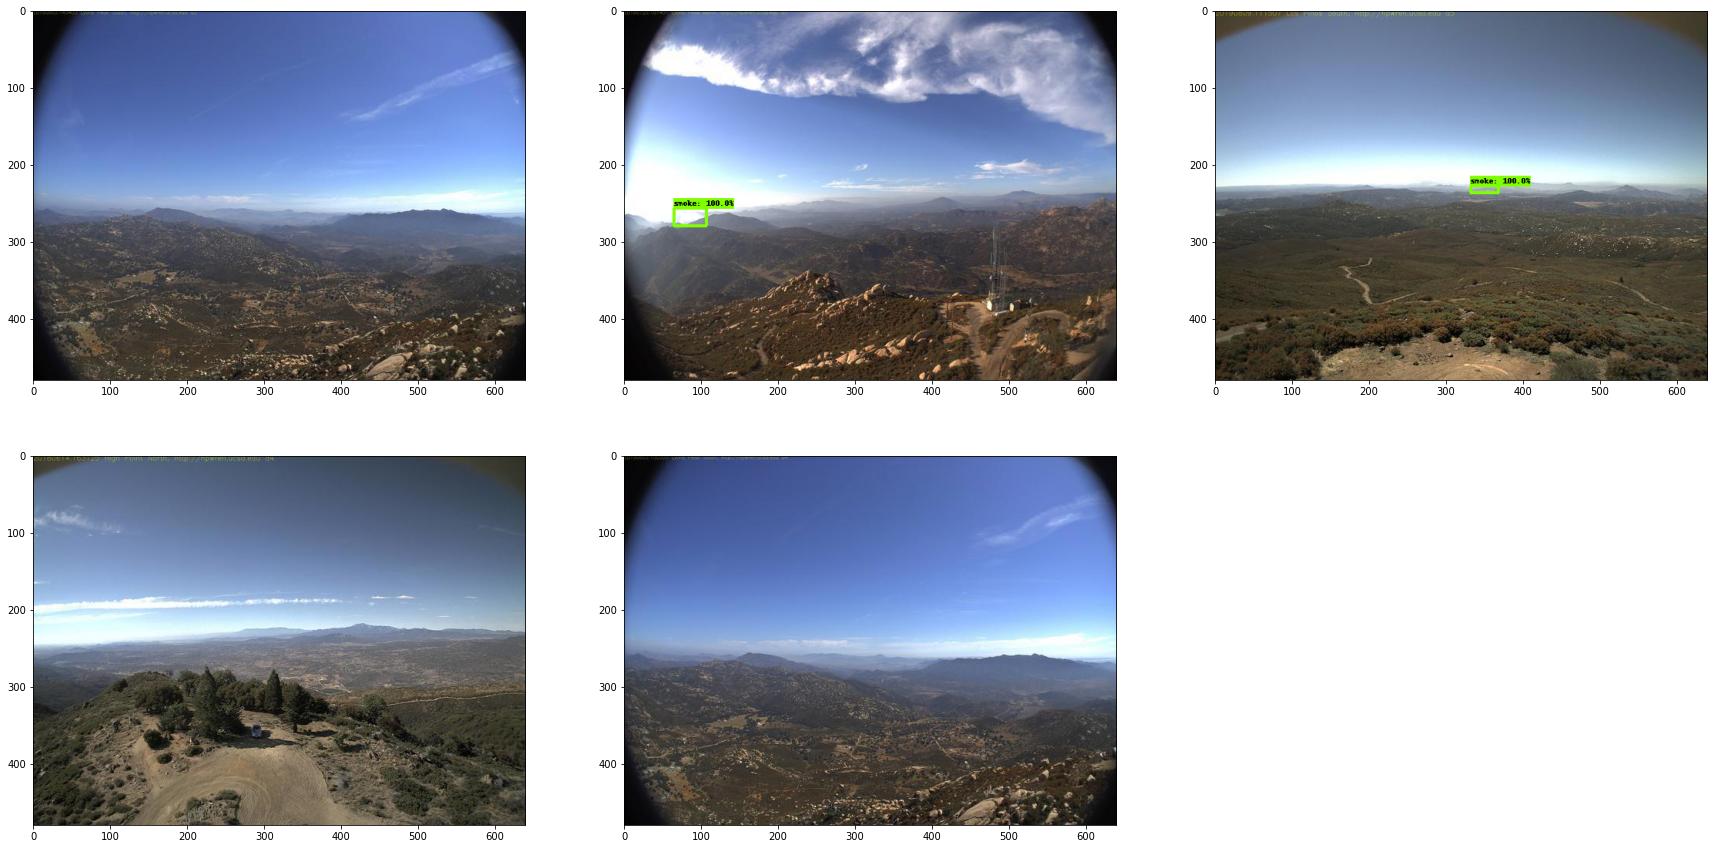

In [34]:
plt.figure(figsize=(30, 15))
for idx in range(5):
  plt.subplot(2, 3, idx+1)
  plot_detections(images_np[idx], boxes[idx], classes[idx], scores, category_index)
plt.show()